In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df0 = pd.read_csv('csv/multi_touch_attribution_data.csv').rename(columns={'User ID':'user_id'})
df0.head()

,user_id,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes


In [3]:
# generate age and income features using the normal distribution with defined ranges
def normal_dist_feature_gen(df, feature, mean, std_dev, min0, max0):

    a = (min0 - mean) / std_dev
    b = (max0 - mean) / std_dev
    values = truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=df.shape[0])

    df[f'{feature}'] =  np.round(values).astype(int)

    df.hist(column=f'{feature}')
    plt.title(f"Synthetic Distribution for Feature '{feature}'")
    plt.show()

    return df

In [4]:
users = df0['user_id'].unique()
df_users = pd.DataFrame({'user_id': users})

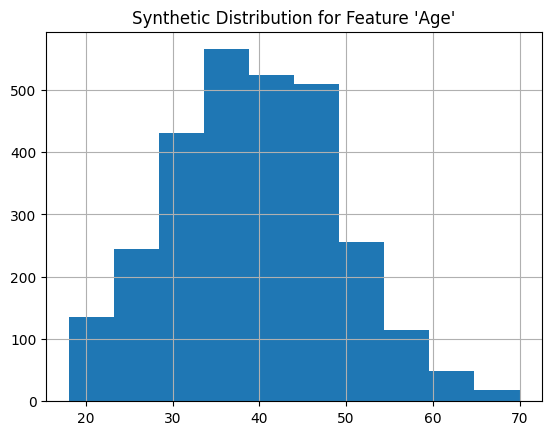

In [5]:
df_users = normal_dist_feature_gen(df=df_users, feature='Age', mean=39, std_dev=10, min0=18, max0=70)

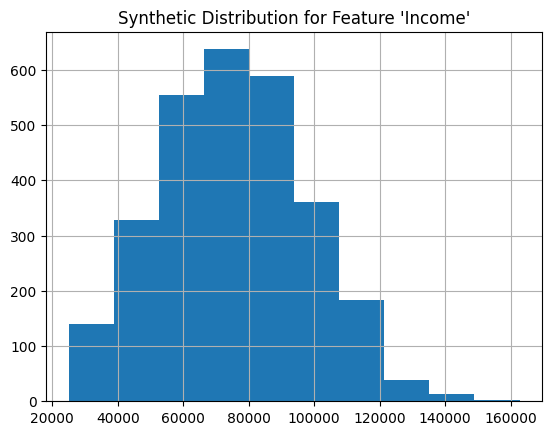

In [6]:
df_users = normal_dist_feature_gen(df=df_users, feature='Income', mean=75000, std_dev=25000, min0=25000, max0=200000)

In [7]:
df1 = df0.merge(df_users, how='left', on = 'user_id')
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
df1.dtypes

user_id                int64
Timestamp     datetime64[ns]
Channel               object
Campaign              object
Conversion            object
Age                    int64
Income                 int64
dtype: object

In [8]:
df_user_touchpoints = df1.groupby('user_id')['Timestamp'].agg(['count']).reset_index().rename(columns={'count':'count_touchpoints'})

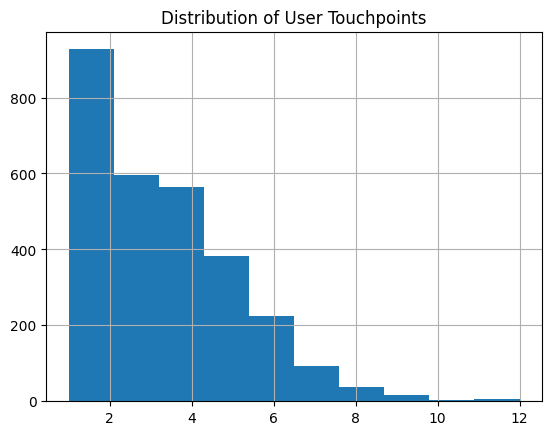

In [9]:
df_user_touchpoints.hist(column='count_touchpoints')
plt.title(f"Distribution of User Touchpoints")
plt.show()

In [10]:
# eoncdoe campaign type
encoder = LabelEncoder()
df1['campaign_touchpoint_id'] = encoder.fit_transform(df1['Campaign'])
df1['channel_id'] = encoder.fit_transform(df1['Channel'])

In [11]:
# create journey_id, but for this use cas all users will only have 1 journey (since this data spans only 2 days)
df1['journey_id'] = 1
df1['converted'] = np.where(df1['Conversion']=='Yes', True, False)

df1 = df1.sort_values(by=['user_id', 'Timestamp'])

In [12]:
# create delta between timestamps and calculate average delta per user

df1['touchpoint_time_delta'] = df1.groupby('user_id')['Timestamp'].diff()
df1['touchpoint_delta_minutes'] = (df1['touchpoint_time_delta'].dt.total_seconds()/60)
df1 = df1.drop(columns=['touchpoint_time_delta'])

df1[df1.user_id==10068].head()

,user_id,Timestamp,Channel,Campaign,Conversion,Age,Income,campaign_touchpoint_id,channel_id,journey_id,converted,touchpoint_delta_minutes
2080,10068,2025-02-10 07:07:39,Search Ads,-,Yes,43,65714,0,4,1,True,NaN
8457,10068,2025-02-11 08:05:04,Social Media,Retargeting,No,43,65714,4,5,1,False,1497.416667
9490,10068,2025-02-11 10:14:02,Social Media,Brand Awareness,Yes,43,65714,1,5,1,True,128.966667
5958,10068,2025-02-11 11:39:02,Search Ads,New Product Launch,Yes,43,65714,3,4,1,True,85.000000
663,10068,2025-02-11 23:05:58,Social Media,Winter Sale,No,43,65714,5,5,1,False,686.933333


### First Channel for each User?

In [13]:
df1['touch_rank'] = df1.groupby('user_id')['Timestamp'].rank(ascending=True)

df_first_channel_by_user = df1[df1.touch_rank==1]

df_first_channel_by_user.groupby('Channel').agg({'user_id':'count'})\
    .reset_index()\
    .rename(columns={'user_id':'count_users', 'Channel':'first_channel'})

,first_channel,count_users
0,Direct Traffic,489
1,Display Ads,492
2,Email,450
3,Referral,486
4,Search Ads,461
5,Social Media,469


##### First channel appears to be uniformly distributed, so this should not cause any issues in training

In [14]:
df1[['Campaign','campaign_touchpoint_id']].drop_duplicates().sort_values('campaign_touchpoint_id')

,Campaign,campaign_touchpoint_id
3633,-,0
8643,Brand Awareness,1
8297,Discount Offer,2
7663,New Product Launch,3
8457,Retargeting,4
663,Winter Sale,5


### Modeling

In [15]:
max_length = df1.groupby('user_id')['Timestamp'].count().max()
max_length

np.int64(12)

In [16]:
num_touchpoints = len(df1.groupby(['Campaign']))
num_touchpoints

6

In [17]:
num_channels = len(df1.groupby(['Channel']))
num_channels

6

In [18]:
journeys = df1.groupby(['user_id']).agg(
    #campaign_list = ('campaign_touchpoint_id', lambda x: x.tolist() + [num_touchpoints] * (max_length - len(x))),
    channel_list = ('channel_id', lambda x: x.tolist() + [num_channels] * (max_length - len(x))), # fill in list with max(i)+1 so all lists are same length
    converted = ('converted', 'any'),
    #avg_touch_delta_minutes = ('touchpoint_delta_minutes', 'mean'),
    age = ('Age', 'min'),
    income = ('Income', 'min')
).reset_index()

In [19]:
journeys[:5]

,user_id,channel_list,converted,age,income
0,10028,"[4, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",True,34,66937
1,10045,"[4, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",True,39,75890
2,10062,"[5, 0, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6]",True,36,81071
3,10068,"[4, 5, 5, 4, 5, 6, 6, 6, 6, 6, 6, 6]",True,43,65714
4,10095,"[1, 2, 3, 1, 4, 3, 6, 6, 6, 6, 6, 6]",True,21,90798


In [20]:
journeys.groupby('converted').agg({'user_id':'nunique'})

,user_id
converted,
False,466
True,2381


In [32]:
# Converted class is too large, so randomly assign False to x% of records
x_percent = 70 # Desired percentage of rows to set to False

# Calculate the number of rows to set to False
num_false_rows = int(len(journeys) * (x_percent / 100))

# Get random indices to set to False
false_indices = np.random.choice(journeys.index, size=num_false_rows, replace=False)

# Assign False to the 'col_boolean' for the selected rows
journeys.loc[false_indices, 'converted'] = False

journeys.groupby('converted').agg({'user_id':'nunique'})

,user_id
converted,
False,2122
True,725


In [33]:
y = torch.tensor(df1.groupby(['user_id']).agg(
    converted = ('converted', 'any')
).converted.values, dtype=torch.float)

In [34]:
class JourneyLSTM(nn.Module):
    def __init__(self, extra_dim:int, journey_dim:int, num_channels: int, hidden_size: int = 64, num_layers: int = 2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.journey_dim = journey_dim
        self.extra_dim = extra_dim
        
        # Embedding layer for channel types
        self.channel_embedding = nn.Embedding(num_channels+1, hidden_size, padding_idx=num_channels)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size + extra_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x:torch.Tensor, lengths=None):
        # x shape: (batch_size, seq_length)
        # Embed channels
        embedded = self.channel_embedding(x[:, -self.journey_dim:].long())  # (batch_size, seq_length, hidden_size)
        
        if lengths is not None:
            # Pack padded sequence
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths, batch_first=True, enforce_sorted=False
            )
            # Process through LSTM
            lstm_out, _ = self.lstm(packed)
            # Unpack
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        else:
            lstm_out, _ = self.lstm(embedded)
        
        # Get final output
        final_hidden = lstm_out[:, -1, :]  # Take last timestep
        out = self.sigmoid(self.fc(torch.cat((final_hidden, x[:, :-self.journey_dim]), dim=1)))
        return out

In [35]:
# define model target as 'channel_list'
transformer = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), ['age','income'])
])

X = torch.tensor(transformer.fit_transform(journeys), dtype=torch.float)
X_journey = torch.tensor(np.stack(journeys.channel_list), dtype=torch.long)

journey_dim = X_journey.shape[1]

In [36]:
X = torch.cat((X, X_journey), dim=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=12)

In [38]:
# num_channels = len(generator.touchpoints)
extra_dim = X_train.shape[1] - journey_dim
model = JourneyLSTM(num_channels=num_channels, journey_dim=journey_dim, extra_dim=extra_dim)

loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) #0.001

In [39]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(initialize_weights)

JourneyLSTM(
  (channel_embedding): Embedding(7, 64, padding_idx=6)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=66, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [40]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64) 
#TODO leverage smaller batch size to regularize and prevent overfitting?

In [43]:
test_recalls = []

n_epochs = 40
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        # Training metrics
        y_pred = model(X_train)
        y_pred_round = y_pred.round()
        train_acc = (y_pred_round == y_train).float().mean()
        train_recall = ((y_pred_round == 1) & (y_train == 1)).sum() / (y_train == 1).sum()

        # Test metrics
        y_pred = model(X_test)
        #y_pred_round = y_pred.round()
        y_pred_round = (y_pred > 0.75).float() # using threshold of 0.5 for binary classification

        test_acc = (y_pred_round == y_test).float().mean()
        test_recall = ((y_pred_round == 1) & (y_test == 1)).sum() / (y_test == 1).sum()
        test_recalls.append(test_recall)
        

    print("Epoch %d: train acc %.4f, train recall %.4f, test acc %.4f, test recall %.4f" % 
          (epoch, train_acc, train_recall, test_acc, test_recall))

Epoch 0: train acc 0.8406, train recall 1.0000, test acc 0.7614, test recall 0.7987
Epoch 10: train acc 0.8406, train recall 0.9979, test acc 0.7789, test recall 0.8394
Epoch 20: train acc 0.8410, train recall 1.0000, test acc 0.7772, test recall 0.8373
Epoch 30: train acc 0.8516, train recall 0.9984, test acc 0.7298, test recall 0.7645


In [45]:
# create dictionary of touchpoint mappings like: {0: 'email', 1: 'social', 2: 'search', 3: 'retargeting', 4: 'direct'}
touchpoint_id_mapping = {row['channel_id']: row['Channel'] for row in df1.to_dict(orient='records')}
touchpoint_id_mapping

{4: 'Search Ads',
 1: 'Display Ads',
 5: 'Social Media',
 0: 'Direct Traffic',
 2: 'Email',
 3: 'Referral'}

Text(0, 0.5, 'Recall')

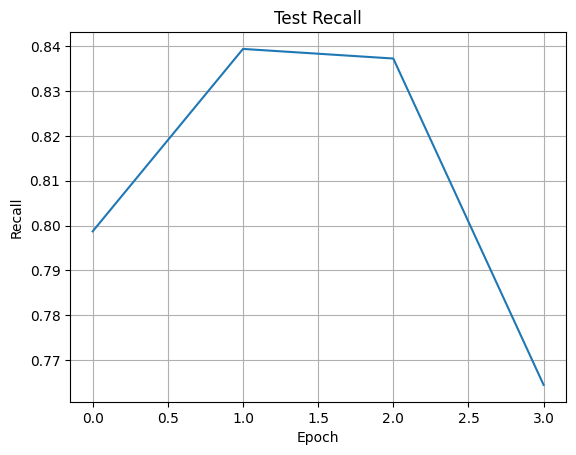

In [46]:
test_recalls = np.array(test_recalls)

fig, ax = plt.subplots()
sns.lineplot(x=np.arange( n_epochs/10), y=test_recalls, ax=ax)
ax.set_title('Test Recall')
ax.set_xlabel('Epoch')
ax.grid()
ax.set_ylabel('Recall')

## Optimization

In [47]:
def apply_constraints(journeys:pd.DataFrame, constraints:dict):
    journeys_c = journeys.copy()
    imposed_journey_list = np.array([ [num_touchpoints] * (max_length)] * len(journeys))

    for pos, channel in constraints.items():
        imposed_journey_list[:, pos] = channel
    imposed_journey_list = imposed_journey_list.tolist()
    journeys_c['imposed_journey_list'] = imposed_journey_list
    journeys_c.drop(columns=['channel_list'], inplace=True)
    return journeys_c

In [48]:
custom_set = journeys.sample(25)
constraints = {0:0}
custom_set = apply_constraints(custom_set, constraints)

X_custom = torch.tensor(transformer.transform(custom_set), dtype=torch.float)
X_custom_journey = torch.tensor(np.stack(custom_set.imposed_journey_list), dtype=torch.long)
X_custom = torch.cat((X_custom, X_custom_journey), dim=1)
custom_set['pred_conv_prob'] = model(X_custom).detach().numpy().flatten()

In [50]:
def beam_search_step(
        model: JourneyLSTM, 
        X: torch.Tensor, 
        pos: int, 
        num_channels: int, 
        max_length: int, 
        constraints:dict[int, int], 
        beam_width: int = 5
    ):
    if pos > max_length:
        return X
    
    if pos in constraints:
        return beam_search_step(model, X, pos + 1, num_channels, max_length, constraints, beam_width)
    
    candidates = []  # List to store (sequence, score) tuples
    
    for sequence_idx in range(min(beam_width, len(X))):
        X_current = X[sequence_idx:sequence_idx+1].clone()
        
        # Try each possible channel
        for channel in range(num_channels):
            X_candidate = X_current.clone()
            X_candidate[0, extra_dim + pos] = channel
            
            # Get prediction score
            pred = model(X_candidate)[0].item()
            candidates.append((X_candidate, pred))
    
    candidates.sort(key=lambda x: x[1], reverse=True)
    best_candidates = candidates[:beam_width]
    
    X_next = torch.cat([cand[0] for cand in best_candidates], dim=0)
    
    # Recurse with best candidates
    return beam_search_step(model, X_next, pos + 1, num_channels, max_length, constraints, beam_width)

In [51]:
start_sequence = X_custom[0:1]  # Start with single sequence
result = beam_search_step(model, start_sequence, pos=0, num_channels=num_touchpoints, max_length=3, constraints=constraints)

for i in range(len(result)):
    journey = result[i, extra_dim:extra_dim+4].int().tolist()
    print(journey)
    channel_names = [touchpoint_id_mapping[c] for c in journey if c < num_touchpoints]
    pred = model(result[i:i+1]).item()
    print(f"Sequence {i+1}: {channel_names}, Score: {pred:.4f}")

[0, 2, 0, 3]
Sequence 1: ['Direct Traffic', 'Email', 'Direct Traffic', 'Referral'], Score: 0.9999
[0, 4, 3, 3]
Sequence 2: ['Direct Traffic', 'Search Ads', 'Referral', 'Referral'], Score: 0.9999
[0, 4, 5, 3]
Sequence 3: ['Direct Traffic', 'Search Ads', 'Social Media', 'Referral'], Score: 0.9999
[0, 4, 5, 2]
Sequence 4: ['Direct Traffic', 'Search Ads', 'Social Media', 'Email'], Score: 0.9999
[0, 5, 3, 4]
Sequence 5: ['Direct Traffic', 'Social Media', 'Referral', 'Search Ads'], Score: 0.9999


In [ ]:
import uuid
from graphviz import Digraph

def beam_search_step_with_viz(
        model: JourneyLSTM, 
        X: torch.Tensor, 
        pos: int, 
        num_channels: int, 
        max_length: int, 
        constraints: dict[int, int], 
        beam_width: int = 5,
        dot=None,
        parent_id=None
    ):
    if dot is None:
        dot = Digraph(comment='Beam Search Tree')
        dot.attr(rankdir='LR')  # Left to right layout
    
    if pos > max_length:
        return X, dot
    
    if pos in constraints:
        return beam_search_step_with_viz(
            model, X, pos + 1, num_channels, max_length, 
            constraints, beam_width, dot, parent_id
        )
    
    candidates = []
    
    for sequence_idx in range(min(beam_width, len(X))):
        X_current = X[sequence_idx:sequence_idx+1].clone()
        current_id = str(uuid.uuid4())
        
        # Calculate conversion probability for current sequence
        conv_prob = model(X_current)[0].item()
        
        # Add node for current sequence with conversion probability
        current_sequence = [touchpoint_id_mapping[int(c)] 
                          for c in X_current[0, extra_dim:extra_dim+pos]
                          if c < num_channels]
        dot.node(current_id, f"{' -> '.join(current_sequence)}\nprob: {conv_prob:.1%}")
        
        if parent_id:
            dot.edge(parent_id, current_id)
        
        # Try each possible channel
        for channel in range(num_channels):
            X_candidate = X_current.clone()
            X_candidate[0, extra_dim + pos] = channel
            
            pred = model(X_candidate)[0].item()
            candidates.append((X_candidate, pred, current_id))
    
    candidates.sort(key=lambda x: x[1], reverse=True)
    best_candidates = candidates[:beam_width]
    
    X_next = torch.cat([cand[0] for cand in best_candidates], dim=0)
    
    # Recurse with best candidates
    return beam_search_step_with_viz(
        model, X_next, pos + 1, num_channels, max_length,
        constraints, beam_width, dot, current_id
    )

# Example usage:
start_sequence = X_custom[0:1]
result, dot = beam_search_step_with_viz(
    model, start_sequence, pos=0, 
    num_channels=num_channels, max_length=3,
    constraints=constraints, beam_width=5
)

# Save visualization
dot.render('beam_search_tree', format='png', cleanup=True)

# Print results as before
for i in range(len(result)):
    journey = result[i, extra_dim:extra_dim+4].int().tolist()
    channel_names = [touchpoint_id_mapping[c] for c in journey if c < num_channels]
    pred = model(result[i:i+1]).item()
    print(f"Sequence {i+1}: {channel_names}, Score: {pred:.4f}")

ERROR! Session/line number was not unique in database. History logging moved to new session 28


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH